In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq as hq
import datetime as dt
import time
import warnings
import pmdarima as pm
import datetime as dt
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)

# Data cleaning and adding 
- start_time
- date
- Interval time

In [2]:
trace = pd.read_csv('Trace2021/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt')
trace["start_timestamp"] = trace["end_timestamp"] - trace["duration"]
trace = trace[['app','func','start_timestamp','end_timestamp','duration']]
trace = trace.rename(columns = {'app': 'app_id', 'func': 'func_id'}, inplace = False)
trace.sort_values(by=['start_timestamp'], ascending=False)

#append the date to the DF
newDate = []
for i in range(0,len(trace)):
    sd = dt.datetime(2021,1,31,0,0,0) # used to output incremental timestamp
    sd = sd + dt.timedelta(seconds = trace['start_timestamp'][i])
    #print(sd)
    newDate.append(sd)
    
#append IT to the DF
listIT = []
tempDict = {}
app_id = trace['app_id']
start_time = trace['start_timestamp']
for i in range(0,len(trace)):
    if tempDict.get(app_id[i]) == None:
        tempDict[app_id[i]] = start_time[i]
        listIT.append(0)
    else:
        IT = start_time[i] - tempDict.get(app_id[i])
        IT = np.floor(IT/60)
        if IT == -1:
            IT = 0
        tempDict[app_id[i]] = start_time[i]
        listIT.append(IT)
trace["date"] = newDate
trace["IT"] = listIT
trace.head()

,app_id,func_id,start_timestamp,end_timestamp,duration,date,IT
0,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,e3cdb48830f66eb8689cc0223514569a69812b77e6611e...,0.001491,0.079491,0.078,2021-01-31 00:00:00.001491,0.0
1,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...,0.003860,57.157860,57.154,2021-01-31 00:00:00.003860,0.0
2,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...,0.005478,59.130478,59.125,2021-01-31 00:00:00.005478,0.0
3,f274d71de386ccc77e4ca74766dbc485461c3053059d47...,3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...,0.016541,6.252541,6.236,2021-01-31 00:00:00.016541,0.0
4,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...,0.016824,0.066824,0.050,2021-01-31 00:00:00.016824,0.0


In [51]:
applicationCounts = trace['app_id'].value_counts().rename_axis('unique_application_id').reset_index(name='counts')
applicationCounts.head(10)

,unique_application_id,counts
0,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,535667
1,a9644719e5d173a27e098cffdd5e9227ba9c4a325d082c...,328885
2,96149d3ed4f00afb92f12856101e693e93c4683f030ae6...,299817
3,7958f89676bf3653f72cda8f38f6b3c0574dcae5169824...,143521
4,62ed48c098820db02aa8e99ad41e5438e61334ba7b1618...,124927
5,70b9cea7ca266637479483f517194c402dfe99b5fc2357...,71837
6,5fb02cfeb979fec16df02d1ece227157238477b19fc6e3...,59798
7,73e9cf25a1a3b312f60ead2177d7d259f128661e3b6763...,34713
8,6e42a4e8ea1df408e059ba37d0e04255fd8385235b3102...,31260
9,734272c01926d19690e5ec308bab64ef97950b75b1c758...,31100


# implementing histogram
- each application is stored in a dictionary as a key
- each key has a list of idle time (IT), with the first position stored as the last invocation time
- histogram will be plotted for every invidual key with bins of 0 to 240 (each bins are of 1mins total 4hour)

In [3]:
#sample data 1: to reflect incoming invocation call
#sampleTest = trace[['app_id','start_timestamp']].head(198095) #around 2 days
sampleTest = trace[['app_id','start_timestamp']].head(1000)
#sampleTest = trace[['app_id','start_timestamp']]
incoming_invocations = sampleTest.values.tolist()
print(sampleTest.tail(10))

                                                app_id  start_timestamp
990  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...      6462.307766
991  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...      6462.520597
992  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...      6463.062487
993  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...      6463.833918
994  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...      6464.271691
995  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...      6464.315677
996  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...      6464.565386
997  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...      6464.802797
998  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...      6465.639181
999  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...      6466.507686


In [87]:
filter_rows = trace.iloc[1000000:1010000]
sampleTest = filter_rows[['app_id','start_timestamp']]
first_row_start_time = sampleTest.iloc[0, 1]
sampleTest['start_timestamp'] = sampleTest['start_timestamp'] - first_row_start_time
sampleTest = sampleTest.reset_index(drop = True)
#append the date to the DF

    
#append IT to the DF
listIT = []
tempDict = {}
app_id = sampleTest['app_id']
start_time = sampleTest['start_timestamp']

for i in range(0,len(sampleTest)):
    if tempDict.get(app_id[i]) == None:
        tempDict[app_id[i]] = start_time[i]
        listIT.append(0)
    else:
        IT = start_time[i] - tempDict.get(app_id[i])
        IT = np.floor(IT/60)
        tempDict[app_id[i]] = start_time[i]
        listIT.append(IT)

sampleTest["IT"] = listIT
sampleTest.head()

incoming_invocations = sampleTest.values.tolist()
print(sampleTest.head(1))
print(sampleTest.tail(1))
sampleTest.head()

                                              app_id  start_timestamp   IT
0  734272c01926d19690e5ec308bab64ef97950b75b1c758...              0.0  0.0
                                                 app_id  start_timestamp   IT
9999  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...     35508.239353  0.0


,app_id,start_timestamp,IT
0,734272c01926d19690e5ec308bab64ef97950b75b1c758...,0.000000,0.0
1,734272c01926d19690e5ec308bab64ef97950b75b1c758...,0.000844,0.0
2,734272c01926d19690e5ec308bab64ef97950b75b1c758...,0.000917,0.0
3,734272c01926d19690e5ec308bab64ef97950b75b1c758...,0.001767,0.0
4,734272c01926d19690e5ec308bab64ef97950b75b1c758...,0.001837,0.0


In [88]:
IT_more_than_240 = sampleTest.loc[sampleTest['IT'] > 240]
IT_more_than_240

,app_id,start_timestamp,IT
9213,4fd9ef036fda3832e6bb4e57f1cc1395c248edddda334e...,32611.741043,406.0
9248,7958f89676bf3653f72cda8f38f6b3c0574dcae5169824...,32927.193228,360.0
9267,18ed3ca44bd1f7d411f1d047ed8cf38853fb184196afa5...,32979.261569,340.0
9600,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,34344.689380,452.0
9871,1de6db5cc9a0296ef5998382d86fe68565054c0a5ede8f...,35199.059522,504.0


In [11]:
incoming_invocations = [['app1', 1], # cold start, new id
['app1', 65], # cold start, IT = 1min, keep alive = current time + 1min
['app1', 130], # cold start, IT = 1min, keep alive 1min = current time + 1min
['app1', 150]] # warm start, 

In [4]:
incoming_invocations = [['app1', 1], # cold start, new id
['app1', 301], # cold start, IT = 1min, keep alive = current time + 1min
['app1', 362], # cold start, IT = 1min, keep alive 1min = current time + 1min
['app1', 483],
['app1', 664]  
                       ] # warm start, 

In [13]:
#try 4 hour prediction
incoming_invocations = [['app1', 1], # cold start, new id
['app2', 5], # cold start, IT = 1min, keep alive = current time + 1min
['app1', 10], # cold start, IT = 1min, keep alive 1min = current time + 1min
['app3', 15],
['app1', 20] ,
['app4', 23],
['app5', 27] ,
['app3', 30],
['app1', 35] ,
['app3', 40],
['app1', 45] ] # warm start, 

df = pd.DataFrame(incoming_invocations)
df.rename(columns = {0:'app_id',1:'start_timestamp'}, inplace = True)
df

,app_id,start_timestamp
0,app1,1
1,app2,5
2,app1,10
3,app3,15
4,app1,20
5,app4,23
6,app5,27
7,app3,30
8,app1,35
9,app3,40


In [4]:
incoming_invocations = [['app1', 1],['app1', 125], ['app1', 200]]

In [82]:
incoming_invocations = [['app1', 1]]

# testing to check if the idle time formula is correct

In [3]:
df = pd.DataFrame(incoming_invocations)
df.rename(columns = {0:'app_id',1:'start_timestamp'}, inplace = True)
df

NameError: name 'incoming_invocations' is not defined

In [30]:
#append IT to the DF
listIT = []
tempDict = {}
app_id = df['app_id']
start_time = df['start_timestamp']
for i in range(0,len(df)):
    if tempDict.get(app_id[i]) == None:
        tempDict[app_id[i]] = start_time[i]
        listIT.append(0)
    else:
        IT = start_time[i] - tempDict.get(app_id[i])
        IT = np.floor(IT/60)
        tempDict[app_id[i]] = start_time[i]
        listIT.append(IT)

df["IT"] = listIT
incoming_invocations = df.values.tolist()
df.head()

,app_id,start_timestamp,IT
0,app1,1,0.0
1,app1,301,5.0
2,app1,362,1.0
3,app1,483,2.0
4,app1,664,3.0


# how an application will be stored in a dictionary: 
{ 
'application1': [datetime.datetime(2023, 3, 12, 2, 0, 22, 60499),  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0], <br>
 'application2': [datetime.datetime(2023, 3, 12, 2, 0, 22, 60499),  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0] 
 }
- key: app_id
- value: list of idle time (IT) for every invocation (first position of the list contains the most recent invocation time)
- first element of the value is the latest function invocation time


# keep_alive_list parameters:
Priority heap queue: [(12.5, "app1"), (100, "app2"), (150, "app3")]
- (keep alive until, application_id)
- keep alive until is calculated by (current time + pre warm time + keep alive time)

# pre_warm_list parameters:
priority heap queue: [(30, "app1","35"), (100, "app2","105)]
- (pre warm until, application_id, keep alive until)
- keep alive until is calculated by (current time + pre warm time + keep alive time)
- e.g. current time = 10s, pre warm time = 20s, keep alive time = 5s, final outcome = (30, "app1","35")

# Types of simulation modes:
- standard_keep_alive (returns default keep alive time regardless of interval time)
- hybrid_without_OOB_prediction (with hybrid histogram policy without OOB prediction)
- hybrid_with_OOB_prediction (with hybrid histogram policy with OOB prediction)

In [5]:
# dictionary to store all the app_id
applicationDict = {}
# list to store all the current keep alive application id
keep_alive_list = []

pre_warm_list = []

countDict = {
    "warm":0,
    "cold":0,
    "oob":0,
    "oob_prediction":0,
    "default_keepalive":0,
    "histogram_keepalive":0,
    "cold_from_new":0,
    "list_of_cold_or_warm_starts":[]
             }

In [77]:
for i in range(0,100):
    applicationDict['app1'].append(2)

# Simulation v1 functions

In [6]:
default_keep_alive_time = 10
OOB_threshold = 1
percentile_position_cut_off = 12

# when an incoming function has been invoked
def functionInvoked(app_id, mode, debug):
    # application id has not been seen before
    if applicationDict.get(app_id) == None:
        if debug:
            print("NEW app_id: {}".format(app_id))
            print("COLD START BECAUSE OF NEW APPLICATION")
        result.write("NEW app_id: {} \n".format(app_id))
        result.write("COLD START BECAUSE OF NEW APPLICATION \n")
        applicationDict[app_id] = []
        applicationDict[app_id].append(dt.datetime.now())
        countDict["default_keepalive"] += 1
        countDict["cold_from_new"] += 1
        #countDict["list_of_cold_or_warm_starts"].append(1)
        return 0, default_keep_alive_time
    
    # application id is already in the dictionary
    else:
        
        
        curTime = dt.datetime.now()
        # calculate idle time (IT) by datetime.now - last previous invoked timing
        IT = curTime - applicationDict[app_id][0]
        IT = np.floor(IT.seconds/60)
        #IT = 241
        if debug:
            print("OLD app_id: {} ".format(app_id))
            print('IDLE TIME (IT) for application is: {} mins'.format(IT))
        result.write("OLD app_id: {} \n".format(app_id))
        result.write('IDLE TIME (IT) for applicationis: {} \n'.format(IT))
        #add idle time into list
        applicationDict[app_id].append(IT)
        applicationDict[app_id][0] = curTime
        
        if(mode == 'standard_keep_alive'):
            if debug:
                print('standard keep alive mode... returning default keep alive time')
            result.write('standard keep alive mode... returning default keep alive time \n')
            countDict["default_keepalive"] += 1
            return 0, default_keep_alive_time
        
        # if the idle time is more than 240mins, return predicted time as it is out of bounds (OOB)
        
        if (IT > 240):
            if debug:
                print('application is OOB with idle time(IT) > 240')
            result.write('application is OOB with idle time(IT) > 240 \n')
            
            if mode == 'hybrid_without_OOB_prediction':
                if debug:
                    print('application is OOB but mode is without OOB prediction, returning default keep alive time')
                result.write('application is OOB but mode is without OOB prediction, returning default keep alive time \n')
                countDict["default_keepalive"] += 1
                return 0, default_keep_alive_time
            
            return predictIntervalTiming(app_id,debug)   
        # add the IT into the dictionary and plot the histogram to determine the TTL duration (mins)
        else:
            return plotHistogram(app_id,debug)
            
# hybrid histogram policy
# categorise the histogram into 240 different minutes bins, returning the bin with the highest amount of frequency
# in the event of same frequency, return the lowest number bin
def plotHistogram(app_id,debug):
    appData = applicationDict[app_id][1:]
    
    # Plot histogram with 240 bins ranging from 0 to 240
    counts, bins, _ = plt.hist(appData, bins=240, range=(0, 240), density=False, edgecolor='black')
    
    #check if histogram is representative
    CV = calculateCV(counts)
    
    if debug:
        print('appplication IT data is: {}'.format(appData))
        print('calculating CV = ',CV)
    #result.write('appplication IT data is: {} \n'.format(appData))
    result.write('CV = {} \n'.format(CV))
    
    if CV < 1:
        result.write('Histogram is not representative \n')
        if debug:
            print('Histogram is not representative')
        countDict["default_keepalive"] += 1
        return 0, default_keep_alive_time
    result.write('Histogram is representative \n')
    if debug:
        print('Histogram is representative')
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')

    # Show the plot
    #plt.show()
    plt.close()
    #show the array of IT
    #print(counts) 
    data = counts.tolist()

    countDict["histogram_keepalive"] += 1
    
    # the pre-warming list
    #head = data[:percentile_position_cut_off] 
    # the keep-alive list
    #tail = data[percentile_position_cut_off:]
    #pre_warm_time = head.index(max(head))
    #keep_alive_time = tail.index(max(tail))
    
    keep_alive_time = data.index(max(data))
    
    if keep_alive_time < 2:
        return 0, 1
    else:
        #TODO
        #split the keep alive time into [80,20], 80% pre warm -10% for buffer and 20% keep alive +10% for buffer
        head = (keep_alive_time * 0.8)
        tail = (keep_alive_time * 0.3)
        return head, tail

def checkForColdStart(keep_alive_list, app_id,debug):
    index = next((i for i, (value1, value2) in enumerate(keep_alive_list) if value2 == app_id), None)
    
    if index is not None:
        if debug:
            print("WARM START")
        result.write("WARM START \n")
        countDict["warm"] += 1
        countDict["list_of_cold_or_warm_starts"].append(0)
    else:
        if debug:
            print("COLD START")
        result.write("COLD START \n")
        countDict["cold"] += 1
        countDict["list_of_cold_or_warm_starts"].append(1)
    
def updateKeepAliveElement(keep_alive_list, new_time, app_id):
    # Find the index of the element you want to update
    index = next((i for i, (value1, value2) in enumerate(keep_alive_list) if value2 == app_id), None)

    if index is not None:
        # Update the value of the element
        keep_alive_list[index] = (new_time, keep_alive_list[index][1])
        # Rebuild the heap
        hq.heapify(keep_alive_list)
        keep_alive_list.sort()
#         print("WARM START")
#         result.write("WARM START \n")
#         countDict["warm"] += 1
#         countDict["list_of_cold_or_warm_starts"].append(0)
    else:
        hq.heappush(keep_alive_list, (new_time, app_id))
#         print("COLD START")
#         result.write("COLD START \n")
#         countDict["cold"] += 1
#         countDict["list_of_cold_or_warm_starts"].append(1)
        
def updatePreWarmingElement(pre_warm_list, new_time, app_id, keep_alive_time):
    #Find the index of the element you want to update
    index = next((i for i, (value1, value2, value3) in enumerate(pre_warm_list) if value2 == app_id), None)
    if index is not None:
        # Update the value of the element
        pre_warm_list[index] = (new_time, pre_warm_list[index][1], keep_alive_time)
        # Rebuild the heap
        hq.heapify(pre_warm_list)
        pre_warm_list.sort()
    else:
        hq.heappush(pre_warm_list, (new_time, app_id, keep_alive_time))
        
def removeKeepAliveIfAny(keep_alive_list, app_id):
    index = next((i for i, (value1, value2) in enumerate(keep_alive_list) if value2 == app_id), None)
    
    if index is not None:
        keep_alive_list[index] = keep_alive_list[-1]
        keep_alive_list.pop()
        hq.heapify(keep_alive_list)

# Welford’s online algorithm (CV) to determine wheather a histogram is representive or not
def calculateCV(app_bins):
    N = len(app_bins)
    M = 0
    S = 0

    for k in range(1, N+1):
        x = app_bins[k-1]
        oldM = M
        M = M + (x - M) / k
        S = S + (x - M) * (x - oldM)
    
    return S / (N - 1)
    

def printPreWarmList(debug):
    if debug:
        print("pre warm list: {}".format(pre_warm_list))
    result.write("pre warm list: {} \n".format(pre_warm_list))
    
def printKeepAliveList(debug):
    if debug:
        print("keep alive list: {}".format(keep_alive_list))
    result.write("keep alive list: {} \n".format(keep_alive_list))
    
def printExpiredPreWarmList(debug):
    if debug:
        print("PRE-WARMING: {} has expired".format(pre_warm_list[0][1]))
    result.write("PRE-WARMING: {} has expired \n".format(pre_warm_list[0][1]))
    
def printExpiredKeepAliveList(debug):
    if debug:
        print("KEEP-ALIVE: {} container has expired".format(keep_alive_list[0][1]))
    result.write("KEEP-ALIVE: {} container has expired \n".format(keep_alive_list[0][1]))

def printStats():
    print("Printing simulation results...")
    print("Number of cold starts:",countDict["cold"])
    print("Number of cold starts from first time invocation:",countDict["cold_from_new"])
    print("Number of warm starts:",countDict["warm"])
    print("Number of default keep alive:",countDict["default_keepalive"]) #not representative
    print("Number of histogram prediction:",countDict["histogram_keepalive"]) #representative
    print("Number of OOB:",countDict["oob"]) #out of 4hours histogram range
    print("Number of OOB arima prediction:",countDict["oob_prediction"])
    print("List of Cold Starts: ",countDict["list_of_cold_or_warm_starts"])
    
    result.write("Printing simulation results...\n")
    result.write("Number of cold starts: {} \n".format(countDict["cold"]))
    result.write("Number of cold starts from first time invocation: {} \n".format(countDict["cold_from_new"]))
    result.write("Number of warm starts: {} \n".format(countDict["warm"],"\n"))
    result.write("Number of default keep alive: {} \n".format(countDict["default_keepalive"]))
    result.write("Number of histogram prediction: {} \n".format(countDict["histogram_keepalive"]))
    result.write("Number of OOB: {} \n".format(countDict["oob"]))
    result.write("Number of OOB arima prediction: {} \n".format(countDict["oob_prediction"]))
    result.write("List of Cold Starts: {} \n".format(countDict["list_of_cold_or_warm_starts"]))
    

# simulation
in this simulation, we have 2 kinds of timer, difference_timer and delta_timer.
- difference_timer: incrementally increasing in time since the start for time calculation
- delta_timer: printing of simulation's current time (every 1 second)

In [7]:
def simulateWithTimer(mode,dbug):
    
    start_time = dt.datetime.now()
    timer = dt.datetime(2021,1,31,0,0,0) # used to output incremental timestamp
    timer_temp = dt.datetime.now() # used to check for every second
#     result = open("result.txt","w") # output logs into a txt file as data is large
    stop_time_seconds = 32400 # how long should the program run
    debug = dbug

    while True:
        # accumulating seconds to track to check for incoming functions as well as calculating time to live (TTL)
        difference_timer = dt.datetime.now()-start_time 

        #non-incremental timer to check if 1sec has lapsed
        delta_timer = dt.datetime.now()-timer_temp

        #print out every second incrementally
        if delta_timer.seconds >= 1:
            timer = timer + dt.timedelta(0,1)
            print(timer.time())
            #print(dt.datetime.now())
            result.write("{}\n".format(timer.time()))
            timer_temp = dt.datetime.now()

        #if still have functions pending invocation
        if len(incoming_invocations) != 0:
            #while(True):
            # since the start_time column is sorted, the first index is always the first to be invoked
            incoming_application_time = dt.timedelta(seconds=incoming_invocations[0][1])
            if(difference_timer >= incoming_application_time):

                if debug:
                    print("TRIGGERED: application has been invoked")
                result.write("TRIGGERED: application has been invoked \n")

                # here the return is the histogram output, 10mins for default, else histogram or predicted output
                pre_warm_time, keep_alive_time = functionInvoked(incoming_invocations[0][0],mode,debug)
                if debug:
                    print("PRE WARM:",pre_warm_time, " KEEP ALIVE:",keep_alive_time)
                result.write("PRE WARM: {}  KEEP ALIVE: {} \n".format(pre_warm_time,keep_alive_time))

                checkForColdStart(keep_alive_list, incoming_invocations[0][0],debug)

                if(pre_warm_time > 0):
                    pre_warm_timer = difference_timer + dt.timedelta(minutes = pre_warm_time)
                    alive_timer = difference_timer + dt.timedelta(minutes = pre_warm_time) + dt.timedelta(minutes = keep_alive_time)
                    if debug:
                        print("pre warm until ",pre_warm_timer)
                    updatePreWarmingElement(pre_warm_list, pre_warm_timer.total_seconds(), incoming_invocations[0][0], alive_timer.total_seconds())
                    printPreWarmList(debug)
                    removeKeepAliveIfAny(keep_alive_list, incoming_invocations[0][0])
                    printKeepAliveList(debug)

                # if pre warming time = 0
                else:
                    if(keep_alive_time > 0):
                        if debug:
                            print("keep alive time is: {} mins".format(keep_alive_time))
                        result.write("keep alive time is: {} mins \n".format(keep_alive_time))
                        alive_timer = difference_timer + dt.timedelta(minutes = keep_alive_time)
                        if debug:
                            print("keep alive until: {}".format(alive_timer.total_seconds()))
                        #hq.heappush(keep_alive_list,(alive_timer.total_seconds(),incoming_invocations[0][0]))
                        updateKeepAliveElement(keep_alive_list, alive_timer.total_seconds(), incoming_invocations[0][0])
                        printKeepAliveList(debug)
                del incoming_invocations[0]

        # as long as there is still applications in the pre-warming list, we will keep checking
        if len(pre_warm_list) != 0:
            # since the TTL list is a heap queue, the first position is always the earliest terminated one
            # so we check if first element is pending expiry, then remove from heap queue
            check_expiry = pre_warm_list[0][0]
            # check if current simulation time has caught up with the application's TTL timing
            if difference_timer.total_seconds() >= check_expiry:
                printExpiredPreWarmList(debug)
                pre_warm_timer, app_id, keep_alive_timer = hq.heappop(pre_warm_list)
                if debug:
                    print("Adding application into keep alive list...")
                result.write("Adding application into keep alive list...")
                updateKeepAliveElement(keep_alive_list, keep_alive_timer, app_id)
                printPreWarmList(debug)
                printKeepAliveList(debug)

        # as long as there is still applications in the keep alive list, we will keep checking
        if len(keep_alive_list) != 0:
            # since the TTL list is a heap queue, the first position is always the earliest terminated one
            # so we check if first element is pending expiry, then remove from heap queue
            check_expiry = keep_alive_list[0][0]
            # check if current simulation time has caught up with the application's TTL timing
            if difference_timer.total_seconds() >= check_expiry:
                printExpiredKeepAliveList(debug)
                hq.heappop(keep_alive_list)
                printKeepAliveList(debug)


        #terminate program if exceeded input time
        if (dt.datetime.now() - start_time).seconds >= stop_time_seconds:
            break
        if len(incoming_invocations) == 0:
            break
        time.sleep(0.5)

    print("==end of run==")
    printStats()
    result.write("==end of run==\n")
    return countDict
#     result.close()

# Simulation 1: Only default keep alive time (No Histogram policy)

In [ ]:
# dictionary to store all the app_id
applicationDict = {}
# list to store all the current keep alive application id
keep_alive_list = []

pre_warm_list = []

countDict = {
    "warm":0,
    "cold":0,
    "oob":0,
    "oob_prediction":0,
    "default_keepalive":0,
    "histogram_keepalive":0,
    "cold_from_new":0,
    "list_of_cold_or_warm_starts":[]
             }

#incoming_invocations = [['app1', 1],['app1', 125], ['app1', 200]]

result = open("standard_keep_alive.txt","w") # output logs into a txt file as data is large
standard_result = simulateWithTimer('standard_keep_alive', 1)
result.close()

# Simulation 2: Histogram policy without OOB prediction (auto arima)

In [8]:
# dictionary to store all the app_id
applicationDict = {}
# list to store all the current keep alive application id
keep_alive_list = []

pre_warm_list = []

countDict = {
    "warm":0,
    "cold":0,
    "oob":0,
    "oob_prediction":0,
    "default_keepalive":0,
    "histogram_keepalive":0,
    "cold_from_new":0,
    "list_of_cold_or_warm_starts":[]
             }

#incoming_invocations = [['app1', 1],['app1', 125], ['app1', 200]]

result = open("hybrid_result_without.txt","w") # output logs into a txt file as data is large
hybrid_result_without = simulateWithTimer('hybrid_without_OOB_prediction', 1)
result.close()

00:00:01
TRIGGERED: application has been invoked
NEW app_id: app1
COLD START BECAUSE OF NEW APPLICATION
PRE WARM: 0  KEEP ALIVE: 10
COLD START
keep alive time is: 10 mins
keep alive until: 601.002588
keep alive list: [(601.002588, 'app1')]
00:00:02
00:00:03
00:00:04
00:00:05
00:00:06
00:00:07
00:00:08
00:00:09
00:00:10
00:00:11
00:00:12
00:00:13
00:00:14
00:00:15
00:00:16
00:00:17
00:00:18
00:00:19
00:00:20
00:00:21
00:00:22
00:00:23
00:00:24
00:00:25
00:00:26
00:00:27
00:00:28
00:00:29
00:00:30
00:00:31
00:00:32
00:00:33
00:00:34
00:00:35
00:00:36
00:00:37
00:00:38
00:00:39
00:00:40
00:00:41
00:00:42
00:00:43
00:00:44
00:00:45
00:00:46
00:00:47
00:00:48
00:00:49
00:00:50


KeyboardInterrupt: 

# Simulation 3: Histogram policy with OOB prediction (auto arima)

In [7]:
# dictionary to store all the app_id
applicationDict = {}
# list to store all the current keep alive application id
keep_alive_list = []

pre_warm_list = []

countDict = {
    "warm":0,
    "cold":0,
    "oob":0,
    "oob_prediction":0,
    "default_keepalive":0,
    "histogram_keepalive":0,
    "cold_from_new":0,
    "list_of_cold_or_warm_starts":[]
}
#incoming_invocations = [['app1', 1],['app1', 125], ['app1', 200]]

result = open("hybrid_result_with.txt","w") # output logs into a txt file as data is large
hybrid_result_with = simulateWithTimer('hybrid_with_OOB_prediction', 1)
result.close()

00:00:01
00:00:02
00:00:03
00:00:04
00:00:05
00:00:06
00:00:07
00:00:08
00:00:09
00:00:10
00:00:11
00:00:12
00:00:13
00:00:14
00:00:15
00:00:16
00:00:17
00:00:18


KeyboardInterrupt: 

# simulation result

In [14]:
standard_keep_alive = [1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
hybrid_keep_alive = [1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
result_trace = sampleTest
result_trace['cold_start_standard'] = standard_keep_alive
result_trace['cold_start_hybrid'] = hybrid_keep_alive
result_trace

,app_id,start_timestamp,cold_start_standard,cold_start_hybrid
0,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,0.001491,1,1
1,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,0.003860,1,1
2,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,0.005478,0,0
3,f274d71de386ccc77e4ca74766dbc485461c3053059d47...,0.016541,1,1
4,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,0.016824,0,0


In [18]:
testdf = result_trace[["app_id","cold_start_standard","cold_start_hybrid"]].groupby(['app_id']).sum()
testdf

,cold_start_standard,cold_start_hybrid
app_id,,
1573b95c039e51cc012b543a4af3bc7c3ee9485acbb0033ba5648b74969e0556,1,1
1661c8faccd5c7ce3ba6d326dc7fb1f14e74bc7d2c2f48a72fd50f6a9f31d44a,4,4
17c37a0fdd5d1932b755c0e6447137bc08fd524f455e14fdac414f584de08dc5,1,41
18ed3ca44bd1f7d411f1d047ed8cf38853fb184196afa59e91e68e5d06fda834,1,4
4b22cc3e1988174edd67d91fd7a82a9977c1719601065e5740d54074a6910170,1,1
5fb02cfeb979fec16df02d1ece227157238477b19fc6e37554e2e2af6018d3ba,4,4
734272c01926d19690e5ec308bab64ef97950b75b1c7582283e0783fce1751d8,1,21
7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de05270735055950a568,1,1
7d37cefc5c5fd0c861664e80fed91c786518aa3635b855890c1a53c01700158c,1,9


# testing area

In [25]:
result_trace

,app_id,start_timestamp,cold_start_standard,cold_start_hybrid
0,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,0.001491,1,1
1,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,0.003860,1,1
2,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,0.005478,0,0
3,f274d71de386ccc77e4ca74766dbc485461c3053059d47...,0.016541,1,1
4,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,0.016824,0,0
5,f7bfe5bc8d2a37a5c15986fbfc2c477a746e866adcb966...,0.021991,1,1
6,85479ef37b5dc75dd5aeca3bab499129b97a134dac5d74...,0.022979,1,1
7,85479ef37b5dc75dd5aeca3bab499129b97a134dac5d74...,0.023016,0,0
8,85479ef37b5dc75dd5aeca3bab499129b97a134dac5d74...,0.023188,0,0
9,85479ef37b5dc75dd5aeca3bab499129b97a134dac5d74...,0.023287,0,0


In [84]:
updateKeepAliveElement(keep_alive_list,1,'app52')
keep_alive_list

[(1, 'app2'), (1, 'app51'), (1, 'app57'), (1, 'app56'), (1, 'app52')]

In [92]:
removeKeepAliveIfAny(keep_alive_list,'app56')
keep_alive_list

[]

# Simulation Results
- plot with different CV
- plot with different keep alive time
- plot number of cold start

In [11]:
x = x = np.sort(testdf["cold_start_standard"])
y = np.arange(1, len(x)+1) / len(x)

x1 = np.sort(testdf["cold_start_hybrid"])
y1 = np.arange(1, len(x1)+1) / len(x1)

# cold_start = plt.plot(x,y)
# cold_start = plt.xticks(x, fontsize=10)
# cold_start = plt.xlabel('app cold start %')
# cold_start = plt.ylabel('CDF')

# Create the plot
fig, ax = plt.subplots()
ax.plot(x, y, label = "standard keep alive (10mins)")
ax.plot(x1,y1,label = "hybrid histogram policy")

# Set the x-axis to a logarithmic scale
#ax.set_xscale('log')

# Set the tick locations and labels for the x-axis
# ax.set_xticks([0,0.25,0.50,0.75,1])
# ax.set_xticklabels(['0','0.25','0.50','0.75','1'])

ax.set_xticks([0,1,2,5,10])
ax.set_xticklabels(['0','1','2','5','10'])
fig.set_figwidth(10)
# Display the plot
plt.xlabel('number of application cold starts')
plt.ylabel('CDF')
plt.legend()
plt.show()

#a = function_per_application_count.loc[function_per_application_count['func_counts'] <=1]
#print("{} out of {} applications has only 1 function, {} %".format(len(a), len(function_per_application_count), len(a)/len(function_per_application_count)*100))

NameError: name 'testdf' is not defined

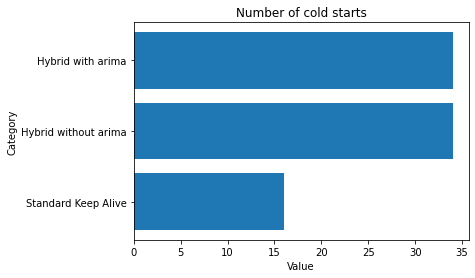

In [9]:
# Sample data
categories = ['Standard Keep Alive', 'Hybrid without arima', 'Hybrid with arima']
values = [16, 34, 34]

# Create the horizontal bar chart
plt.barh(categories, values)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Category')
plt.title('Number of cold starts')

# Display the chart
plt.show()

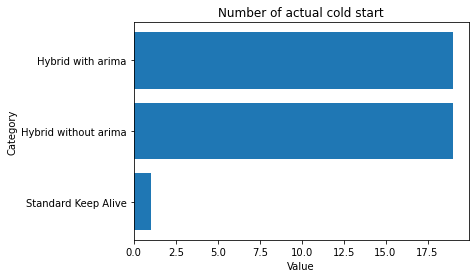

In [10]:
# Sample data
categories = ['Standard Keep Alive', 'Hybrid without arima', 'Hybrid with arima']
values = [1, 19, 19]

# Create the horizontal bar chart
plt.barh(categories, values)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Category')
plt.title('Number of actual cold start')

# Display the chart
plt.show()

In [ ]:
for key,value in may28_3hr_dict.items():
    print(key)

# test CV

In [ ]:
sample_bin1 = [0] * 240
sample_bin2 = [0] * 240
sample_bin1[1] = 3
sample_bin2[1] = 20

In [ ]:
print("sample_bin1 CV = {}".format(calculateCV(sample_bin1)))
print("sample_bin2 CV = {}".format(calculateCV(sample_bin2)))

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load/split your data
y = pm.datasets.load_wineind()
train, test = train_test_split(y, train_size=150)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:150], train, c='blue')
plt.plot(x[150:], forecasts, c='green')
plt.show()

# testing for auto arima

In [ ]:
#traces of IT > 240
df = trace[['date','IT']]
df.set_index('date',inplace=True)
IT_more_than_240 = df.loc[df['IT'] > 240]
#IT_more_than_240.set_index('date',inplace=True)

print("{} of IT > 240".format(len(IT_more_than_240)))
IT_more_than_240.head()

In [ ]:
#traces of IT < 240
IT_less_than_240 = df.loc[df['IT'] <= 240]
#IT_less_than_240.set_index('date',inplace=True)

print("{} of IT <= 240".format(len(IT_less_than_240)))
IT_less_than_240.head()

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3,sharex=True, sharey=True, figsize=(15, 5))
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
ax1.set_xlabel('Normal IT')
ax2.set_xlabel('IT < 240')
ax3.set_xlabel('IT > 240')

ax1.plot(df)
ax2.plot(IT_less_than_240)
ax3.plot(IT_more_than_240)

In [ ]:
start = len(option1_train)
end = len(option1_train) + len(option1_test) -1
option1_predict = model1.predict(n_periods=len(option1_test))

option1_df = app
option1_predict.index = option1_df.index[start:end+1]
option1_df['forecast'] = [None]*len(option1_train) + list(option1_predict)

#clearer_image = option1_df.iloc[-1386665:]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')


ax1.plot(option1_df)
#ax2.plot(clearer_image)

In [ ]:
from sklearn import metrics

print("Mean:",option1_test['IT'].mean())
#print("MSE:",metrics.mean_squared_error(option2_test['IT'],option2_predict))
print("RMSE:",np.sqrt(metrics.mean_squared_error(option1_test['IT'],option1_predict)))

In [12]:
countDict = {
    "cold_start":1170,
    "cold_from_new":31,
    "warm_start":8830,
    "default_keepalive":884,
    "histogram_keepalive":9111,
    "oob":5,
    "oob_prediction":5,
    "list_of_cold_or_warm_starts":[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
             }

In [13]:
resultDict

{'cold_start': 1170,
 'cold_from_new': 31,
 'warm_start': 8830,
 'default_keepalive': 884,
 'histogram_keepalive': 9111,
 'oob': 5,
 'oob_prediction': 5,
 'list_of_cold_or_warm_starts': [1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
